In [1]:
import sys
print(sys.executable)


c:\Users\huawei\AppData\Local\Programs\Python\Python311\python.exe


In [2]:
import os
os.environ["PYSPARK_PYTHON"] = sys.executable


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, when, lit, concat_ws

# 1. Start Spark session
spark = SparkSession.builder \
    .appName("Amazon Sentiment ML") \
    .getOrCreate()

# 2. Load the dataset (CSV format)
df = spark.read.csv("../data/Musical_instruments_reviews.csv", header=True, inferSchema=True)

In [4]:
df = df.withColumn("full_review", 
    concat_ws(" ", 
        when(col("summary").isNull(), "").otherwise(col("summary")),
        when(col("reviewText").isNull(), "").otherwise(col("reviewText"))
    ))

In [5]:
from pyspark.sql.functions import col, lower, regexp_replace, trim

df = df.withColumn("full_review", lower(col("full_review")))  # 1. Tout en minuscule

df = df.withColumn("full_review", regexp_replace(col("full_review"), "[^a-zA-ZÀ-ÿ\\s]", " "))  # 2. Supprimer ponctuation et symboles

df = df.withColumn("full_review", regexp_replace(col("full_review"), "\\s+", " "))  # 3. Supprimer les espaces multiples

df = df.withColumn("full_review", trim(col("full_review")))  # 4. Supprimer les espaces au début/fin


In [6]:
df = df.withColumn("label", 
                      when(col("overall") <= 2, 1)
                      .when(col("overall") == 3, 2)
                      .otherwise(0))

In [7]:
df.select("full_review", "overall", "label").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----+
|full_review                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
# import nltk
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# import nltk
#nltk.download('all')

In [8]:
from pyspark.sql.functions import col, when, concat_ws, lit, trim, rand, length, avg, count

target_size = 2000

class_0 = df.filter(col("label") == 0)
class_1 = df.filter(col("label") == 1)
class_2 = df.filter(col("label") == 2)

# Check if we need to oversample or undersample
c0_count = class_0.count()
c1_count = class_1.count()
c2_count = class_2.count()

print(f"\nClass counts before balancing: Negative: {c0_count}, Neutral: {c1_count}, Positive: {c2_count}")

# Modified oversampling function with a safety check
def balance_class(df_class, target, class_name):
    current_count = df_class.count()
    if current_count == 0:
        print(f"WARNING: No samples in {class_name} class. Cannot balance.")
        return df_class
    
    if current_count < target:
        # Oversample
        ratio = int(target / current_count) + 1
        oversampled = df_class
        for _ in range(ratio - 1):
            oversampled = oversampled.union(df_class)
        return oversampled.orderBy(rand()).limit(target)
    else:
        # Undersample
        return df_class.orderBy(rand()).limit(target)

print("\n🔁 Balancing dataset...")
balanced_1 = balance_class(class_1, target_size, "negative")
balanced_2 = balance_class(class_2, target_size, "neutral")
balanced_0 = balance_class(class_0, target_size, "positive")

df_balanced = balanced_0.union(balanced_1).union(balanced_2).orderBy(rand())

print("\n✅ Balanced class distribution:")
df_balanced.groupBy("label").agg(count("*").alias("count")).orderBy("label").show()




Class counts before balancing: Negative: 9139, Neutral: 422, Positive: 699

🔁 Balancing dataset...

✅ Balanced class distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0| 2000|
|    1| 2000|
|    2| 2000|
+-----+-----+



In [9]:
from pyspark.sql.functions import col, when, concat_ws, lit, trim, rand, length, avg, count
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tokenizer = Tokenizer(inputCol="full_review", outputCol="words")

stopwords = StopWordsRemover(inputCol="words", outputCol="filtered")

count_vec = CountVectorizer(inputCol="filtered", outputCol="raw_features", vocabSize=10000, minDF=5)

idf = IDF(inputCol="raw_features", outputCol="features")

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth=20, seed=42)

pipeline = Pipeline(stages=[tokenizer, stopwords, count_vec, idf, rf])

In [10]:
train_df, val_df, test_df = df_balanced.randomSplit([0.8, 0.1, 0.1], seed=42)


In [11]:

model = pipeline.fit(train_df) 


In [ ]:

# val_final = model.transform(val_df)    # Uses vocab/IDF from training
# test_final = model.transform(test_df)

In [12]:
# 1) Raw counts per class in validation
print("Validation set distribution:")
val_df.groupBy("label") \
      .count() \
      .orderBy("label") \
      .show(truncate=False)

# 2) Raw counts per class in test
print("Test set distribution:")
test_df.groupBy("label") \
       .count() \
       .orderBy("label") \
       .show(truncate=False)


Validation set distribution:
+-----+-----+
|label|count|
+-----+-----+
|0    |198  |
|1    |197  |
|2    |192  |
+-----+-----+

Test set distribution:
+-----+-----+
|label|count|
+-----+-----+
|0    |194  |
|1    |173  |
|2    |200  |
+-----+-----+



In [13]:
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 2) Define a helper to do the conversion + report
def sk_report(predictions, name):
    # pull out the two columns into Pandas
    pdf = predictions.select("label", "prediction").toPandas()
    y_true = pdf["label"].astype(int)
    y_pred = pdf["prediction"].astype(int)
    
    # map your numeric codes to human names
    label_names = {0: "positive", 1: "negative", 2: "neutral"}
    target_names = [label_names[i] for i in sorted(label_names)]
    
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(
        y_true,
        y_pred,
        labels=sorted(label_names),
        target_names=target_names,
        digits=3
    ))
    print(f"=== {name} Confusion Matrix ===")
    print(confusion_matrix(y_true, y_pred, labels=sorted(label_names)))

# 3) Generate predictions on your splits
val_pred  = model.transform(val_df)
test_pred = model.transform(test_df)

# 4) (Optional) also show overall accuracy via Spark
spark_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
print(f"\nValidation Accuracy: {spark_acc.evaluate(val_pred):.3f}")
print(f"Test       Accuracy: {spark_acc.evaluate(test_pred):.3f}")

# 5) Print the full reports
sk_report(val_pred,  "Validation")
sk_report(test_pred, "Test")



Validation Accuracy: 0.855
Test       Accuracy: 0.850

=== Validation Classification Report ===
              precision    recall  f1-score   support

    positive      0.844     0.768     0.804       198
    negative      0.907     0.939     0.923       197
     neutral      0.813     0.859     0.835       192

    accuracy                          0.855       587
   macro avg      0.855     0.855     0.854       587
weighted avg      0.855     0.855     0.854       587

=== Validation Confusion Matrix ===
[[152  11  35]
 [  9 185   3]
 [ 19   8 165]]

=== Test Classification Report ===
              precision    recall  f1-score   support

    positive      0.819     0.794     0.806       194
    negative      0.925     0.925     0.925       173
     neutral      0.816     0.840     0.828       200

    accuracy                          0.850       567
   macro avg      0.853     0.853     0.853       567
weighted avg      0.850     0.850     0.850       567

=== Test Confusion Matr

In [14]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, NaiveBayes, MultilayerPerceptronClassifier


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1) Re-use your preprocessing stages:
tokenizer         = Tokenizer(inputCol="full_review", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words",       outputCol="filtered")
vectorizer        = CountVectorizer(inputCol="filtered",    outputCol="rawFeatures", vocabSize=5000)
idf               = IDF(inputCol="rawFeatures",             outputCol="features")

# 2) Define the two models
lr = LogisticRegression(
    featuresCol="features", labelCol="label",
    maxIter=20, regParam=0.1, family="multinomial"
)
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(
    featuresCol="features", 
    labelCol="label",
    smoothing=1.0  # Handles zero probabilities in text data
)
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    layers=[5000, 100, 3],
    maxIter=100,               # you can tune
    blockSize=128,             # batch size
    seed=42
)

# 3) Build two pipelines
pipe_lr  = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, lr])
pipe_nb = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, nb])
pipe_mlp = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, mlp])

# 4) Fit both on balanced training data
model_lr  = pipe_lr .fit(train_df)
model_nb = pipe_nb.fit(train_df)
model_mlp = pipe_mlp.fit(train_df)

# 5) Generate predictions on test set
pred_lr  = model_lr .transform(test_df)
pred_nb = model_nb.transform(test_df)
pred_mlp = model_mlp.transform(test_df)


🔎 LogisticRegression Test Accuracy = 0.9242
🔎 NBClassifier      Test Accuracy = 0.7795
🔎 MLPClassifier      Test Accuracy = 0.9330

=== LogisticRegression Classification Report ===
              precision    recall  f1-score   support

    negative      0.966     0.983     0.974       173
     neutral      0.873     0.965     0.917       200
    positive      0.947     0.830     0.885       194

    accuracy                          0.924       567
   macro avg      0.929     0.926     0.925       567
weighted avg      0.927     0.924     0.923       567



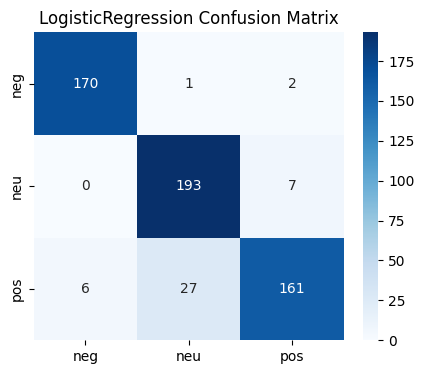


=== NBClassifier Classification Report ===
              precision    recall  f1-score   support

    negative      0.855     0.821     0.838       173
     neutral      0.716     0.770     0.742       200
    positive      0.785     0.753     0.768       194

    accuracy                          0.780       567
   macro avg      0.786     0.781     0.783       567
weighted avg      0.782     0.780     0.780       567



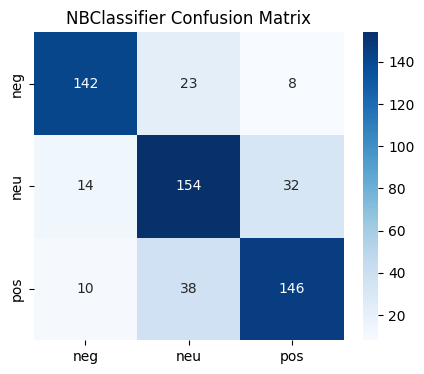


=== MLP Classification Report ===
              precision    recall  f1-score   support

    negative      0.966     1.000     0.983       173
     neutral      0.875     0.980     0.925       200
    positive      0.976     0.825     0.894       194

    accuracy                          0.933       567
   macro avg      0.939     0.935     0.934       567
weighted avg      0.937     0.933     0.932       567



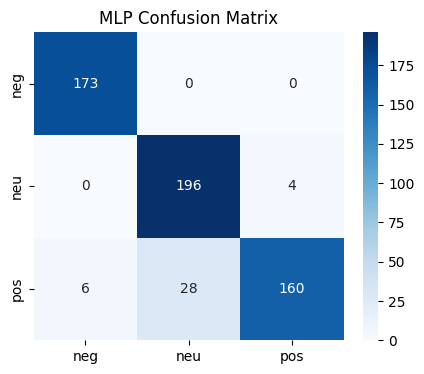

In [15]:
# 6) Spark evaluator for overall accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
print(f"\n🔎 LogisticRegression Test Accuracy = {evaluator.evaluate(pred_lr):.4f}")
print(f"🔎 NBClassifier      Test Accuracy = {evaluator.evaluate(pred_nb):.4f}")
print(f"🔎 MLPClassifier      Test Accuracy = {evaluator.evaluate(pred_mlp):.4f}")

# 7) Convert to pandas and print detailed reports
def detailed_report(pred_lr , model_name):
    pdf = pred_lr .select("label", "prediction").toPandas()
    y_true = pdf["label"].astype(int)
    y_pred = pdf["prediction"].astype(int)
    label_names = {0:"positive",1:"negative",2:"neutral"}
    y_true_named = [label_names[i] for i in y_true]
    y_pred_named = [label_names[i] for i in y_pred]

    print(f"\n=== {model_name} Classification Report ===")
    print(classification_report(
        y_true_named, y_pred_named,
        labels=["negative","neutral","positive"],
        digits=3
    ))
    cm = confusion_matrix(
        y_true_named, y_pred_named,
        labels=["negative","neutral","positive"]
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["neg","neu","pos"],
                yticklabels=["neg","neu","pos"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# 8) Show for both
detailed_report(pred_lr,  "LogisticRegression")
detailed_report(pred_nb, "NBClassifier")
detailed_report(pred_mlp, "MLP")

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluators = {
    "accuracy": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
    "precision": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision"),
    "recall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall"),
    "f1_score": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
}


In [ ]:
results = {}

models = {
    "RandomForest": model,
    "LogisticRegression": model_lr,
    "NaiveBayes": model_nb,
    "MLPClassifier": model_mlp
}

for name, model in models.items():
    predictions = model.transform(test_df)
    metrics = {}
    for metric_name, evaluator in evaluators.items():
        metrics[metric_name] = evaluator.evaluate(predictions)
    results[name] = metrics

# Convert to Pandas DataFrame for easy comparison
import pandas as pd

results_df = pd.DataFrame(results).T
results_df["average_score"] = results_df.mean(axis=1)
best_model_name = results_df["average_score"].idxmax()
print("✅ Evaluation results:")
display(results_df.round(4))
print(f"🏆 Best model is: {best_model_name}")

best_model = models[best_model_name]
best_model.save("best_model")  



✅ Evaluation results:


,accuracy,precision,recall,f1_score,average_score
RandomForest,0.9330,0.9373,0.9330,0.9319,0.9338
LogisticRegression,0.9242,0.9268,0.9242,0.9233,0.9246
NaiveBayes,0.7795,0.7822,0.7795,0.7803,0.7804
MLPClassifier,0.9330,0.9373,0.9330,0.9319,0.9338


🏆 Best model is: RandomForest
